In [1]:
import qutip, pickle, sys
import matplotlib.pyplot as plt 
import numpy as np
import scipy.optimize as opt 
import scipy.linalg as linalg
import time as time
import math, cmath
import Max_Ent_aux_lib as me
#import proj_ev_library as projev
#import max_entev library as meev
from IPython.display import display, Math, Latex

np.set_printoptions(threshold=1.e-3,linewidth=120,precision=1, formatter={"float":lambda x: str(.001*int(1000*x)) })

Tenemos la siguiente ecuación de movimiento:

$$
    \dot{c}_M(t) I_{M}^{0}(t) = -i \bigg\{\bigg(c_{M+2}(t) - c_M(t) \bigg)\langle \rho_{M}^{0\dagger}(t) [H_{0,-2}, \rho_{M+2}^0] \rangle + \bigg(c_{M-2}(t) - c_M(t)\bigg) \langle \rho_{M}^{0\dagger}(t) [H_{0,2}, \rho_{M-2}^0] \rangle + p \langle \rho_{M}^{0\dagger}(t) [\Sigma, \rho_{M}^0 (t)]\rangle \bigg\}
$$

siendo $I_{M}^{0}(t) = \langle \rho_{M}^{0\dagger}(t) \rho_{M}^{0}(t)\rangle = I_{-M}^{0}(t)$
la cual puede reescribirse como 

$$
\dot{c}_M(t) I_{M}^{0}(t) = -i \bigg\{A_{\rho^{M, M+2}} c_{M+2}(t) - \bigg(A_{\rho^{M, M+2}} + B_{\rho^{M, M-2}} \bigg) c_{M}(t) + B_{\rho^{M, M-2}} c_{M-2}(t) \bigg\} + p C_{\rho^M} \\
= - i({\bf{\mathcal{M}}}(t) \textbf{c}(t))_M
$$

donde 

<ol>

<li> $A_{\rho^{M, M+2}} = \langle \rho_{M}^{0\dagger}(t) [H_{0,-2}, \rho_{M+2}^0] \rangle$ </li> 
<li> $B_{\rho^{M, M-2}} = \langle \rho_{M}^{0\dagger}(t) [H_{0,2}, \rho_{M-2}^0] \rangle$ </li>
<li> $C_{\rho^M} = \langle \rho_{M}^{0\dagger}(t) [\Sigma, \rho_{M}^0 (t)]\rangle$ </li>
    
</ol>    

Entonces, si $f(t) = \langle \rho(t) \rho^0(t) \rangle = \sum_{M} {c}_M(t) I_{M}^{0}(t)$

$$
    \dot{f}(t) = \sum_{M} \bigg(\dot{c}_M(t) I_{M}^{0}(t) + {c}_M(t) \dot{I}_{M}^{0}(t) \bigg)
$$

where

1: $A=\alpha B = N(t) \exp(-m t^{1+a}) = I_M^{(0)}$ (a primer orden alpha = 1) \
2: $C = M N(t) exp(-m t^{1+a})$

con $N(t) = 1/Tr(\rho(t))$ la calculo con la definición del $\rho_M (t)=  c_{M}(t) \rho^0_M(t)$, with $c_0(t)$= 1. 
Note that the kernel, $K(t,t') = e^{(-i M(t-t'))}$, is not a solution to the previous differential equation. for a power law factor $a \neq -1$, since, in that case, the M-matrix is time-dependent 
    
$H_ {0, 2}^\dagger = H_{0, -2}$ 

$\rho_{M}^\dagger = \rho_{-M}$

Las cM(t) no deberían estar normalizadas

## Step 1: Fix parameters and initial conditions for the coherences

In [2]:
p = .108;    # strength of the Sigma Interaction Hamiltonian
a = -1.;      # Power-law factor
M = 700;        # Truncation/Total no. of coherences
param_list = {"total_no_cohrs": M, "p_factor": p, "power_law_factor": a} # dictionary containing the simulation's initial 
                                                                         # parameters
    
cohr_complex_t0 = [1 for i in range(param_list["total_no_cohrs"])] 
#cohr_complex_t0 += [0 for i in range(param_list["total_no_cohrs"])]

Since the coherences are complex-valued numbers, the previous system of $M \times M$ coupled complex-valued differential equations can be rewritten as a system of $2M \times 2M$ coupled real-valued differential equations, as follows:

if $c_M(t) = a_M(t) + i b_M(t)$, then 

$$
    \dot{a}_M(t) + i \dot{b}_M(t) = -i \sum_{m'}{\bf{\mathcal{M}}}_{Mm'}(t) \bigg(a_{m'}(t) + i b_{m'}(t)\bigg),
$$

$$
    \dot{a}_M(t) + i \dot{b}_M(t) = -i \sum_{m'}{\bf{\mathcal{M}}}_{Mm'}(t) a_{m'}(t) + \sum_{m'} {\bf{\mathcal{M}}}_{Mm'}(t) b_{m'}(t)
$$

$$
    \dot{{\bf a}}(t) = {\cal M}(t) \cdot {\bf b}(t), \quad \dot{{\bf b}}(t) = -{\cal M}(t) \cdot {\bf a}(t), \qquad s.t. \quad{\bf c}(t) = {\bf a}(t) + i {\bf b}(t)
$$


## Step 2: Setting up and Solving system of complex diff. eqs

In [3]:
param_list = {"total_no_cohrs": M, "p_factor": p, "power_law_factor": a} # dictionary containing the simulation's initial 
                                                                         # parameters 

cohr_complex_t0 = [complex(1) for i in range(param_list["total_no_cohrs"])]
cohr_complex_t0 = np.array(cohr_complex_t0)
param_list = [M, p, a]

In [4]:
Mmatrix1 = qutip.Qobj(me.generating_fnc_even_coherences_Mmatrix(M, p, a, 1))
Mmatrix2 = qutip.Qobj(me.generating_fnc_even_coherences_Mmatrix(M, p, a, 200))

linalg.norm(Mmatrix1 - Mmatrix2)

0.0

In [5]:
from scipy.integrate import solve_ivp
tmax = 20.; no_steps = 100
ts = np.linspace(0, tmax, no_steps)  

def coherences_diff_system(t, y0, M, p, a):
    Mmatrix_local = qutip.Qobj(me.generating_fnc_even_coherences_Mmatrix(M, p, a, t))
    return 1j * Mmatrix_local * y0

sol = solve_ivp(fun = coherences_diff_system, 
                t_span = [0, tmax], 
                y0 = cohr_complex_t0, 
                t_eval=ts,
                args = (M, p, a))

time_ev_cohrs = sol.y ## ahora la evolucion es coherencias para abajo, tiempos para la izq

In [6]:
len(time_ev_cohrs[:,99])

700

In [7]:
time_ev_cohrs[:,99]

array([-0.4+1.j ,  0.3+0.4j,  1. -0.1j, ...,  1. +0.j ,  1. +0.j ,  1. +0.j ])

In [8]:
fidelity_at_timet = []
cluster_spin_size_at_timet = []
timespan = list(ts)

for t in ts:
    local_column = time_ev_cohrs[:,timespan.index(t)]
    local_val = sum(local_column[m] * me.power_law_weight(coherence = m, 
                                                        time = t, 
                                                        power_law_factor = a)
            
                   for m in range(M)) 
    fidelity_at_timet.append(local_val)
    local_val = 0
    local_val = sum(m**2 * local_column[m] * me.power_law_weight(coherence = m, 
                                                                       time = t, 
                                                                       power_law_factor = a)
                   for m in range(M)) 
    cluster_spin_size_at_timet.append(local_val)
    local_val = 0

assert len(fidelity_at_timet) == len(ts)
assert len(cluster_spin_size_at_timet) == len(ts)

# Step 3: Test for $a = -1$ (time-independent case)

In [16]:
p = .108;    # strength of the Sigma Interaction Hamiltonian
a = -1;      # Power-law factor
M = 700;        # Truncation/Total no. of coherences
param_list = {"total_no_cohrs": M, "p_factor": p, "power_law_factor": a} # dictionary containing the simulation's initial 
                                                                         # parameters 

c0 = [1 for i in range(param_list["total_no_cohrs"])]
param_list = [M, p, -1]

In [17]:
Mmatrix = me.generating_fnc_even_coherences_Mmatrix(M, p, a,
                                                    time = 0) 
Mmatrix_timet = me.generating_fnc_even_coherences_Mmatrix(M, p, a,
                                                    time = 10) 

Mmatrix = np.array(Mmatrix)
assert linalg.norm(qutip.Qobj(Mmatrix) - qutip.Qobj(Mmatrix_timet))<1e-5, "Error: Mmatrix is time-dependent"
assert linalg.norm(qutip.Qobj(Mmatrix) - qutip.Qobj(Mmatrix).dag())>1e-5, "Error: Mmatrix is not hermitian"
assert np.all([np.imag(qutip.Qobj(Mmatrix).eigenenergies()) < 1e-5]), "Error: Eigenvalues of Mmatrix not real"
assert np.all(np.imag(qutip.Qobj(Mmatrix).eigenenergies())<1e-10), "Error: Eigenvalues of Mmatrix are not real"

Mmatrix

array([[0.721, 0.013000000000000001, 0.0, ..., 0.0, 0.0, 0.0],
       [0.265, -0.502, 0.265, ..., 0.0, 0.0, 0.0],
       [0.0, 0.013000000000000001, -0.023, ..., 0.0, 0.0, 0.0],
       ...,
       [0.0, 0.0, 0.0, ..., 0.0, 0.0, 0.0],
       [0.0, 0.0, 0.0, ..., 0.0, 0.0, 0.0],
       [0.0, 0.0, 0.0, ..., 0.0, 0.0, 0.0]])

In [18]:
np.all([np.imag(qutip.Qobj(Mmatrix).eigenenergies()) < 1e-5])

True

In [19]:
tmax = 20; no_steps = 100
ts = np.linspace(0, tmax, no_steps)     
coherences_at_timet = [linalg.expm(1j * Mmatrix * t) @ c0 for t in ts]

In [20]:
fidelity_at_timet_exact = []
cluster_spin_size_at_timet_exact = []
timespan = list(ts)

for t in ts:
    local_list = coherences_at_timet[timespan.index(t)]
    local_val = sum(local_list[m] * me.power_law_weight(coherence = m, 
                                                        time = t, 
                                                        power_law_factor = a)
                   for m in range(M)) 
    fidelity_at_timet_exact.append(local_val)
    local_val = 0
    local_val = sum(m**2 * local_list[m] * me.power_law_weight(coherence = m, 
                                                                       time = t, 
                                                                       power_law_factor = a)
                   for m in range(M)) 
    cluster_spin_size_at_timet_exact.append(local_val)
    local_val = 0
    
assert len(fidelity_at_timet) == len(ts)
assert len(cluster_spin_size_at_timet) == len(ts)

In [27]:
difference_fidelity = [fidelity_at_timet_exact[t] - fidelity_at_timet[t] for t in range(len(ts))]
difference_cluster = [cluster_spin_size_at_timet_exact[t] - cluster_spin_size_at_timet[t] for t in range(len(ts))]

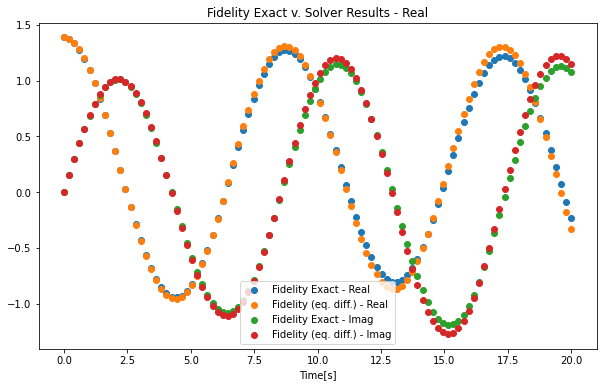

In [35]:
fig0, ax0 = plt.subplots(figsize=(10,6))

plt.title("Fidelity Exact v. Solver Results - Real")
plt.scatter(ts, np.real(fidelity_at_timet_exact), label = "Fidelity Exact - Real")
plt.scatter(ts, np.real(fidelity_at_timet), label = "Fidelity (eq. diff.) - Real")

plt.scatter(ts, np.imag(fidelity_at_timet_exact), label = "Fidelity Exact - Imag")
plt.scatter(ts, np.imag(fidelity_at_timet), label = "Fidelity (eq. diff.) - Imag")

ax0.legend(loc = 0)
plt.xlabel("Time[s]")
plt.show()

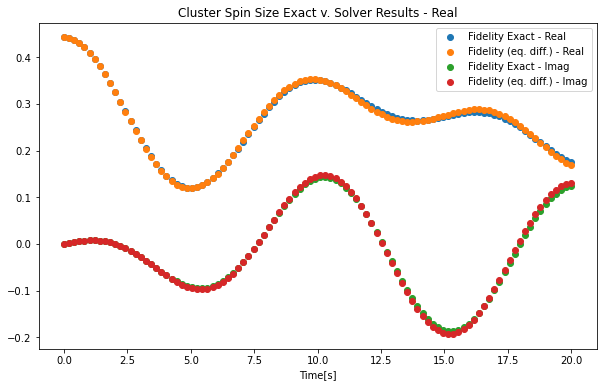

In [36]:
fig0, ax0 = plt.subplots(figsize=(10,6))

plt.title("Cluster Spin Size Exact v. Solver Results - Real")
plt.scatter(ts, np.real(cluster_spin_size_at_timet_exact), label = "Fidelity Exact - Real")
plt.scatter(ts, np.real(cluster_spin_size_at_timet), label = "Fidelity (eq. diff.) - Real")

plt.scatter(ts, np.imag(cluster_spin_size_at_timet_exact), label = "Fidelity Exact - Imag")
plt.scatter(ts, np.imag(cluster_spin_size_at_timet), label = "Fidelity (eq. diff.) - Imag")

ax0.legend(loc = 0)
plt.xlabel("Time[s]")
plt.show()

In [6]:
Mmatrix = me.antidiagonal_2M2M_block_Mmatrix(time=2, M = M, p = p, a = a, qutip_qobj_result = False)
qutip.Qobj(Mmatrix)

Quantum object: dims = [[10], [10]], shape = (10, 10), type = oper, isherm = False
Qobj data =
[[0.0 0.0 0.0 ... 0.0 0.0 0.0]
 [0.0 0.0 0.0 ... 0.10400000000000001 0.0 0.0]
 [0.0 0.0 0.0 ... 0.0 0.0 0.0]
 ...
 [0.0 0.0 0.0 ... 0.0 0.0 0.0]
 [0.0 0.0 0.0 ... 0.0 0.0 0.0]
 [0.0 0.0 0.0 ... 0.0 0.0 0.0]]

In [7]:
B = me.complex_differential_system(time=2, M = M, p = p, a = a, coherences_init_configs = cohr_complex_t0)
print(B[6])

0.01133114816089123


In [8]:
assert linalg.norm(Mmatrix)>1e-5, "Error: The Mmatrix is null"
assert linalg.norm(qutip.Qobj(Mmatrix) - qutip.Qobj(Mmatrix).dag())<1e-5, "Error: The Mmatrix is not hermitian"

AssertionError: Error: The Mmatrix is not hermitian

In [9]:
.5 * (qutip.Qobj(Mmatrix) + qutip.Qobj(Mmatrix).dag())

Quantum object: dims = [[10], [10]], shape = (10, 10), type = oper, isherm = True
Qobj data =
[[0.0 0.0 0.0 ... 0.0 0.0 0.0]
 [0.0 0.0 0.0 ... 0.052000000000000005 0.0 0.0]
 [0.0 0.0 0.0 ... 0.0 0.0 0.0]
 ...
 [0.0 0.052000000000000005 0.0 ... 0.0 0.0 0.0]
 [0.0 0.0 0.0 ... 0.0 0.0 0.0]
 [0.0 0.0 0.0 ... 0.0 0.0 0.0]]

In [21]:
Mtensor_simple = me.generating_fnc_even_coherences_Mmatrix(param_list, 1)
qutip.Qobj(Mtensor_simple)

Quantum object: dims = [[5], [5]], shape = (5, 5), type = oper, isherm = False
Qobj data =
[[0.721 0.013000000000000001 0.0 0.0 0.0]
 [0.265 -0.502 0.265 0.0 0.0]
 [0.0 0.013000000000000001 -0.023 0.013000000000000001 0.0]
 [0.0 0.0 0.0 0.0 0.0]
 [0.0 0.0 0.0 0.0 0.0]]

In [14]:
from scipy.integrate import solve_ivp
tmax = 2.; no_steps = 1000
ts = np.linspace(0, tmax, no_steps)  

def complex_diff_system(t, y0, M, p, a):
    Mmatrix_local = me.antidiagonal_2M2M_block_Mmatrix(time = t, 
                                                       M = M, p = p, a = a)
    Mmatrix_local = np.array(Mmatrix_local)
    Mmatrix_local = .5 * Mmatrix_local + .5 * np.transpose(Mmatrix_local)
    return Mmatrix_local @ y0

sol = solve_ivp(fun = complex_diff_system, 
                t_span = [0, tmax], 
                y0 = cohr_complex_t0, 
                t_eval=ts,
                methods = "LSODA",
                args = (M, p, a))
time_ev_ReIm_cohrs = sol.y

C:\Users\tomas\anaconda3\lib\site-packages\scipy\integrate\_ivp\common.py:39: UserWarning: The following arguments have no effect for a chosen solver: `methods`.
  warn("The following arguments have no effect for a chosen solver: {}."


In [116]:
time_ev_ReIm_cohrs ## ahora la evolucion es coherencias para abajo, tiempos para la izq

array([[1.0, 1.0, 1.0, ..., 2.591, 2.596, 2.602],
       [1.0, 1.0, 1.0, ..., 1.832, 1.834, 1.837],
       [1.0, 1.0, 1.0, ..., 1.0170000000000001, 1.0170000000000001, 1.0170000000000001],
       ...,
       [0.0, 0.0, 0.0, ..., 0.151, 0.152, 0.152],
       [0.0, 0.0, 0.0, ..., 0.059000000000000004, 0.059000000000000004, 0.059000000000000004],
       [0.0, 0.0, 0.001, ..., 0.218, 0.218, 0.218]])

## Step 3: Obtaining the time-evolved complex-valued coherences


Ideally, the observables of interest obtained via our coherences should show this trend 

<img src="PhD%20Physics/2nd%20Year/RMN-Max-Ent/Decoherence_..._scrambling_Dominguez_ib_observables" width=60 height=60 />

In [118]:
complex_cohrs_at_time_t = [[time_ev_ReIm_cohrs[m][list(ts).index(t)] + 1j*time_ev_ReIm_cohrs[m+M][list(ts).index(t)] for m in range(M)] for t in ts]
complex_cohrs_at_time_t = np.array(complex_cohrs_at_time_t)

complex_cohrs_at_time_t_local_sum =  sum(complex_cohrs_at_time_t[100][m] * me.power_law_weight(coherence = m, 
                                                        time = 100, 
                                                        power_law_factor = a)
                                        for m in range(M))

In [120]:
complex_cohrs_at_time_t_local_sum

(1.0022754451274771+0.09190802144729893j)

Entonces, si

$$
    f(t) = \langle \rho(t) \rho^0(t) \rangle = \sum_{M}{c}_M(t) I_{M}^{0}(t)
$$

then

$$
    \dot{f}(t) = \sum_{M} \bigg(\dot{c}_M(t) I_{M}^{0}(t) + {c}_M(t) \dot{I}_{M}^{0}(t) \bigg)
$$

EXTRAIGO RE(f(t))
#complex_cohrs_at_time_t[99][599]
sum_{m} m**2 cm(t) * I_m(0)(t)

In [121]:
fidelity_at_timet = []
cluster_spin_size_at_timet = []
timespan = list(ts)

for t in ts:
    local_list = complex_cohrs_at_time_t[timespan.index(t)]
    local_val = sum(local_list[m] * me.power_law_weight(coherence = m, 
                                                        time = t, 
                                                        power_law_factor = a)
            
                   for m in range(M)) 
    fidelity_at_timet.append(local_val)
    local_val = 0
    local_val = sum(m**2 * local_list[m] * me.power_law_weight(coherence = m, 
                                                                       time = t, 
                                                                       power_law_factor = a)
                   for m in range(M)) 
    cluster_spin_size_at_timet.append(local_val)
    local_val = 0
    
assert len(fidelity_at_timet) == len(ts)
assert len(cluster_spin_size_at_timet) == len(ts)

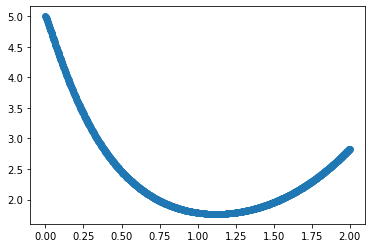

In [122]:
plt.scatter(ts, np.real(fidelity_at_timet))

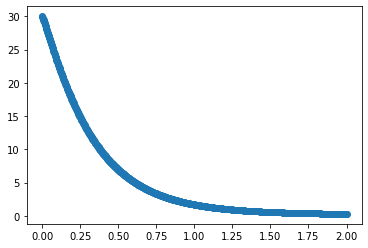

In [123]:
plt.scatter(ts, np.real(cluster_spin_size_at_timet))

# Tests y fallos :(

## Fallo grave

In [32]:
difference_between_solvers = []
for t in ts:
    difference_between_solvers.append(sum(
        coherences_at_timet[timespan.index(t)][i] - complex_cohrs_at_time_t[timespan.index(t)][i] for i in range(5))
                                     )

Text(0.5, 1.0, 'Difference between solutions')

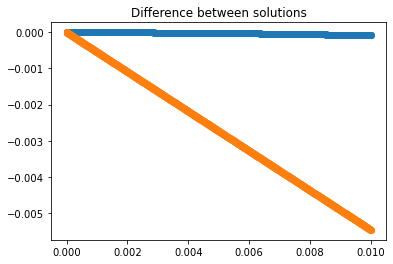

In [33]:
plt.scatter(ts, np.real(difference_between_solvers))
plt.scatter(ts, np.imag(difference_between_solvers))
plt.title("Difference between solutions")